In [15]:
from __future__ import print_function

import sys
import numpy as np
from time import time
import matplotlib.pyplot as plt 
from tqdm import tqdm
import math
import struct
import binascii

sys.path.append('/home/xilinx')
from pynq import Overlay
from pynq import allocate

In [16]:
def float2bytes(fp):
    packNo = struct.pack('>f', np.float32(fp))
    return int(binascii.b2a_hex(packNo), 16)

In [17]:
print("Entry:", sys.argv[0])
print("System argument(s):", len(sys.argv))
print("Start of \"" + sys.argv[0] + "\"")

Entry: /usr/lib/python3/dist-packages/ipykernel_launcher.py
System argument(s): 3
Start of "/usr/lib/python3/dist-packages/ipykernel_launcher.py"


In [18]:
# Overlay and IP
ol = Overlay("/home/xilinx/xrwang/SQA_Opt5.bit")
ipSQA = ol.QuantumMonteCarloOpt5_0
ipDMAIn = ol.axi_dma_0

In [19]:
MAX_NTROT=8
MAX_NSPIN=1024

In [20]:
# Number of Spins and Number of Trotters and Wirte Trotters
numSpins = 1024
numTrotters = 8
trotters = np.random.randint(2, size=(MAX_NTROT*MAX_NSPIN))
k = 0
for addr in tqdm(range(0x400, 0x2400, 0x04)):
    # 8 * 1024 * 1 Byte (it extend boolean into uint8)
    tmp = (trotters[k+3] << 24) + (trotters[k+2] << 16) + (trotters[k+1] << 8) + (trotters[k])
    ipSQA.write(addr, int(tmp))
    k += 4

100%|██████████| 2048/2048 [00:00<00:00, 11539.76it/s]


In [21]:
# Generate Random Numbers
rndNum = np.ndarray(shape=(numSpins), dtype=np.float32)
for i in tqdm(range(numSpins)):
#         rndNum[i] = np.random.randn()
    rndNum[i] = i+1
rndNum /= numSpins

100%|██████████| 1024/1024 [00:00<00:00, 63636.69it/s]


In [22]:
rndNum

array([  9.76562500e-04,   1.95312500e-03,   2.92968750e-03, ...,
         9.98046875e-01,   9.99023438e-01,   1.00000000e+00], dtype=float32)

In [23]:
# Generate J coupling
inBuffer0 = allocate(shape=(numSpins*numSpins), dtype=np.float32)
for i in tqdm(range(numSpins)):
    for j in range(numSpins):
        inBuffer0[i*numSpins+j] = - rndNum[i] * rndNum[j]

100%|██████████| 1024/1024 [00:10<00:00, 100.01it/s]


In [24]:
# Some Constant Kernel Arguments    
ipSQA.write(0x10, numTrotters) # nTrot
ipSQA.write(0x18, numSpins) # nSpin
for addr in range(0x2400, 0x3400, 0x04):
    ipSQA.write(addr, 0) # h[i]

In [25]:
# Iterations Parameters
iter = 500
maxBeta = 8.0
Beta = 1.0 / 4096.0
G0 = 8.0
dBeta = (maxBeta-Beta) / iter

# Iterations
timeList = []
trottersList = []

for i in tqdm(range(iter)):

#     # Write Random Numbers (8*1024*4Bytes)
#     rn = np.random.uniform(0.0, 1.0, size=numTrotters*numSpins)
#     rn = np.log(rn) * numTrotters

    # Generate Jperp
    Gamma = G0 * (1.0 - i/iter)
    Jperp = -0.5 * np.log(np.tanh((Gamma/numTrotters) * Beta)) / Beta

#     # Write Random Nubmers
#     k = 0
#     for addr in range(0x4000, 0xC000, 0x04):
#         ipSQA.write(addr, float2bytes(rn[k]))
#         k += 1

    # Write Beta & Jperp
    ipSQA.write(0x3400, float2bytes(Jperp))
    ipSQA.write(0x3408, float2bytes(Beta))
    
    timeKernelStart = time()
    # Start Kernel
    ipSQA.write(0x00, 0x01)

    # Write Jcoup Stream
    ipDMAIn.sendchannel.transfer(inBuffer0) # Stream of Jcoup
    ipDMAIn.sendchannel.wait()

    # Wait at Here
    while (ipSQA.read(0x00) & 0x04) == 0x0:
        continue
    
    timeKernelEnd = time()
    timeList.append(timeKernelEnd - timeKernelStart)
    
    # Beta Incremental
    Beta += dBeta
    
    k = 0
    newTrotters=np.ndarray(shape=MAX_NTROT*MAX_NSPIN)
    for addr in range(0x400, 0x2400, 0x04):
        # 8 * 1024 * 1 Byte (it extend boolean into uint8)
        tmp = ipSQA.read(addr)
        newTrotters[k] = (tmp) & 0x01
        newTrotters[k+1] = (tmp>>8) & 0x01
        newTrotters[k+2] = (tmp>>16) & 0x01
        newTrotters[k+3] = (tmp>>24) & 0x01
        k += 4
    trottersList.append(newTrotters)
    
    
print("Kernel execution time: " + str(np.sum(timeList)) + " s")

100%|██████████| 500/500 [01:47<00:00,  4.66it/s]

Kernel execution time: 62.5148866177 s


In [26]:
best = (0,0,0,0,10e22)
sumEnergy = []
k = 0
for trotters in tqdm(trottersList):
    a = 0
    b = 0
    sumE = 0
    k += 1
    for t in range(numTrotters):
        for i in range(numSpins):
            if trotters[t*MAX_NSPIN+i] == 0:
                a += rndNum[i]
            else:
                b += rndNum[i]
        E = (a-b)**2
        sumE += E
        if best[4] > E :
            best = (k, t, a, b, E)
    sumEnergy.append(sumE)

100%|██████████| 500/500 [00:55<00:00,  8.86it/s]


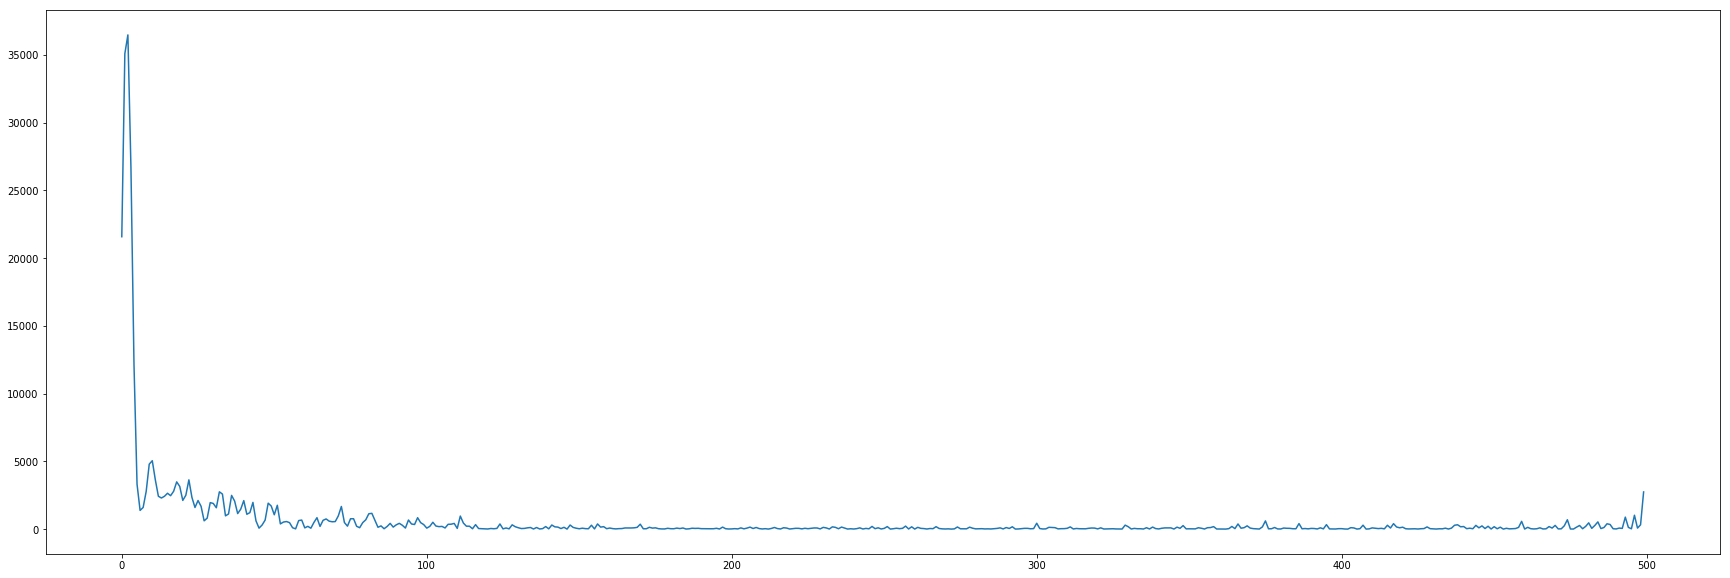

In [27]:
plt.figure(figsize=(30,10))
plt.plot(sumEnergy)

In [28]:
best

(278, 6, 1793.75, 1793.75, 0.0)